In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np

# Objective:

* Try and implement basic DL models using fastai v1 (code from 2019 course v3 DL1), Keras (what I know), Pytorch (learning)

## Project: Pet identifier

* Use Oxford-IIIT Pet Dataset by O. M. Parkhi et al., 2012 which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories.

### Fastai

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
!pip freeze | grep fastai

fastai==1.0.51


You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


#### Data Setup

In [5]:
# batch size
bs = 64

In [6]:
# main path where data is (fastai -> used `path = untar_data(URLs.PETS)` to download/extract data)
path = Path(r"C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet")
path

WindowsPath('C:/Users/Shonket Ray/.fastai/data/oxford-iiit-pet')

In [7]:
# annotations and imgs paths
path_anno = path/'annotations'
path_img = path/'images'
print(path_anno, path_img)

C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet\annotations C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet\images


In [8]:
# display first 5 imgs
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('C:/Users/Shonket Ray/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/Shonket Ray/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/Shonket Ray/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/Shonket Ray/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/Shonket Ray/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

From fastai docstromg: Before any work can be done a dataset needs to be converted into a `DataBunch` object, and in the case of the computer vision data - specifically into an `ImageDataBunch` subclass. ... A list of filenames and a function to get the target from the filename (`ImageDataBunch.from_name_func`)

In [9]:
# set seed, regex for jpg path for ImageDataBunch obj
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [10]:
type(data)

fastai.vision.data.ImageDataBunch

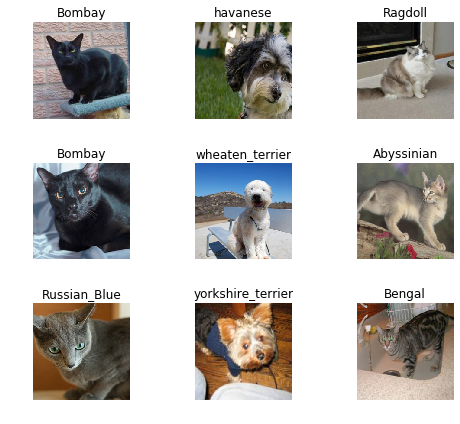

In [11]:
# show batch
data.show_batch(rows=3, figsize=(7,6))

In [12]:
# show classes, num of classes
print(data.classes)
print(len(data.classes),data.c)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
37 37


#### Train model

In [12]:
# build convnet style learner with data from data obj (3 channel rgb imgs)
# pretrained resnet34 architecture (CNN backbone, FC head, output predaprob per each 37 classes)
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# display architecture
print(learn.model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

)


from https://sgugger.github.io/the-1cycle-policy.html

*  Learning rate finder = Begin to train the model while __increasing the learning rate from a very low to a very large one__, stop when the loss starts to really get out of control; Plot the losses against the learning rates and pick a value a bit before the minimum, where the loss still improves.

* Leslie Smith https://arxiv.org/abs/1803.09820  recommends to do a __cycle with two steps of equal lengths__, one going from a lower learning rate to a higher one than go back to the minimum. The __maximum should be the value picked with the Learning Rate Finder__, and the __lower one can be ten times lower__. Then, the __length of this cycle should be slightly less than the total number of epochs__, and, __in the last part of training, we should allow the learning rate to decrease more than the minimum, by several orders of magnitude__.

* Main reason for this cycle procedure: during the middle of the cycle, the __high learning rates will act as regularization__ method, and keep the network from overfitting. They will prevent the model to land in a steep area of the loss function, preferring to __find a minimum that is flatter__.  Last part of the training, with descending learning rates up until annihilation will allow us to go inside a steeper local minimum inside that smoother part. During the par with high learning rates, we don't see substantial improvements in the loss or the accuracy, and the validation loss sometimes spikes very high, but we see all the benefits of doing this when we finally lower the learning rates at the end.

* To accompany the movement toward larger learning rates, Leslie found in his experiments that __decreasing the momentum led to better results__.  we want the SGD to quickly go in new directions to find a flatter area, so the new gradients need to be given more weight. In practice, he recommends to __pick two values likes 0.85 and 0.95__, and __decrease from the higher one to the lower one when we increase the learning rate, then go back to the higher momentum as the learning rate goes down__.

* When we run the Learning Rate Finder, it's __very important to use it with the exact same conditions as during our training__. 

In [14]:
# Fit model with 1=cycle policy (from Leslie Smith paper)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.410665,0.333148,0.092693,02:26
1,0.549131,0.260764,0.089986,01:28
2,0.344407,0.232605,0.077808,01:24
3,0.239604,0.223028,0.073748,01:25


In [18]:
# Save model and optimizer state
learn.save('stage-1', return_path=True)

WindowsPath('C:/Users/Shonket Ray/.fastai/data/oxford-iiit-pet/images/models/stage-1.pth')

In [13]:
# load saved model
learn = learn.load("stage-1")

#### Check out results

In [21]:
# Interpretation methods for classification models.
interp = ClassificationInterpretation.from_learner(learn)
# Returns tuple of (losses,indices), sorted by largest
losses,idxs = interp.top_losses()
# check all equal
len(data.valid_ds)==len(losses)==len(idxs)

True

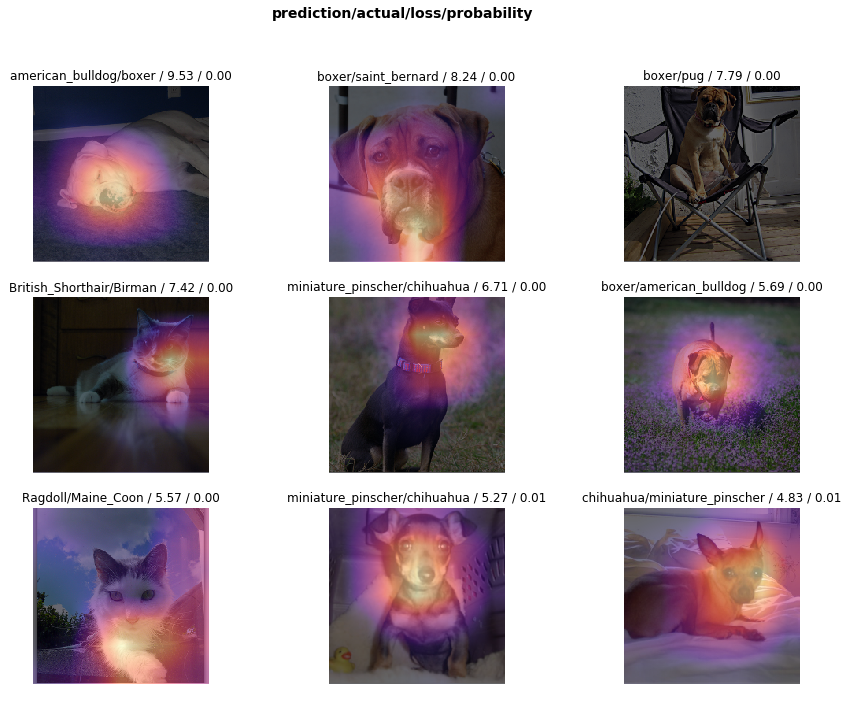

In [22]:
# Show imgs in `top_losses` with prediction, actual, loss, and probability of actual class (+ Grad-CAM heatmaps)
# Grad-CAM -> http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf
interp.plot_top_losses(9, figsize=(15,11))

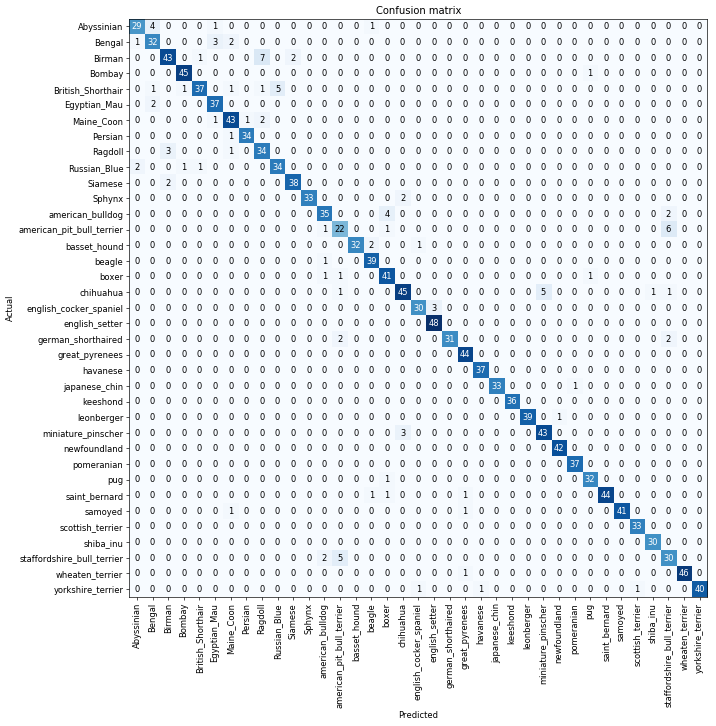

In [24]:
# confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
# Sorted descending list of largest non-diagonal entries of confusion matrix (actual, predicted, num of occurrences)
interp.most_confused(min_val=2)

[('Birman', 'Ragdoll', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('chihuahua', 'miniature_pinscher', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Abyssinian', 'Bengal', 4),
 ('american_bulldog', 'boxer', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Ragdoll', 'Birman', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Bengal', 'Maine_Coon', 2),
 ('Birman', 'Siamese', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Siamese', 'Birman', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('basset_hound', 'beagle', 2),
 ('german_shorthaired', 'american_pit_bull_terrier', 2),
 ('german_shorthaired', 'staffordshire_bull_terrier', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

#### Unfreeze previous model and train some more.

In [14]:
# display saved Learner object
learn

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet\images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_pit_bull_terrier,staffordshire_bull_terrier,Abyssinian,Egyptian_Mau,Maine_Coon
Path: C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet\images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
    

In [15]:
# Unfreeze entire model
learn.unfreeze()

In [16]:
# Now Fit a model following 1cycle policy
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.566878,0.348130,0.109608,02:42


In [17]:
learn.load('stage-1');

In [18]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


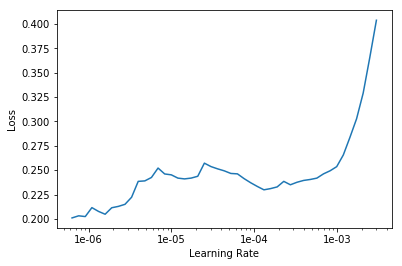

In [19]:
learn.recorder.plot()

In [20]:
# Unfreeze and fit 1cycle policy
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.225964,0.218397,0.066982,04:15
1,0.212308,0.212953,0.064953,03:33


#### Use resnet50 as backbone, a deeper network with more parameters.

In [11]:
bs

64

In [12]:
# modify orig size and bs (size=299, bs=bs//2)
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//4).normalize(imagenet_stats)

In [13]:
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet\images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
american_pit_bull_terrier,keeshond,beagle,english_setter,english_setter
Path: C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet\images;

Test: None

In [14]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


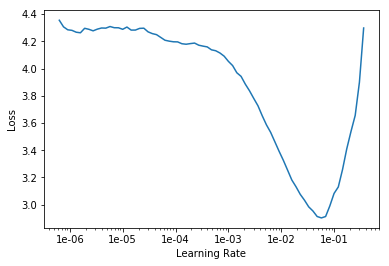

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.608326,0.343205,0.102165,04:23
1,0.506566,0.309746,0.089986,03:58
2,0.400203,0.263950,0.083897,03:57
3,0.318038,0.245445,0.075101,03:57
4,0.293243,0.231907,0.064953,03:58
5,0.179060,0.217052,0.065629,03:57
6,0.143242,0.203839,0.057510,03:58
7,0.144781,0.202067,0.058863,03:58


In [17]:
learn.save('stage-1-50')

In [18]:
# try finetuning
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.177220,0.198535,0.054127,06:59
1,0.139174,0.185292,0.055480,06:56
2,0.129228,0.189913,0.056157,06:56


In [19]:
interp = ClassificationInterpretation.from_learner(learn)

In [20]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('american_bulldog', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Ragdoll', 'Birman', 3),
 ('boxer', 'american_bulldog', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('Abyssinian', 'Sphynx', 2),
 ('Birman', 'Ragdoll', 2),
 ('Birman', 'Siamese', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'boxer', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'havanese', 2),
 ('yorkshire_terrier', 'pomeranian', 2)]